In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
from pyspark.sql.functions import col, explode, count, split, isnan, when, desc, avg,expr
import matplotlib.pyplot as plt
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import matplotlib.pyplot as plt

In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName("MovieRecommendation").getOrCreate()

In [ ]:
# Define the schema for the movie data
schema = StructType([
    StructField("show_id", StringType(), True),
    StructField("type", StringType(), True),
    StructField("title", StringType(), True),
    StructField("director", StringType(), True),
    StructField("cast", StringType(), True),
    StructField("country", StringType(), True),
    StructField("date_added", StringType(), True),
    StructField("release_year", IntegerType(), True),
    StructField("rating", StringType(), True),
    StructField("duration", StringType(), True),
    StructField("listed_in", StringType(), True),
    StructField("description", StringType(), True)
])



In [ ]:
# Load the movie and rating data into Spark dataframes
df = spark.read.csv("netflix_titles.csv", header=True, schema=schema)

# Data Analysis

In [ ]:
# Perform data analysis
num_movies = df.count()
print(f"Number of movies: {num_movies}")

Number of movies: 8809


In [ ]:
# The rating value count
rating_index_counts = df.groupBy("rating").count().orderBy("count", ascending=False)
rating_index_counts.show()


+-----------------+-----+
|           rating|count|
+-----------------+-----+
|            TV-MA| 3195|
|            TV-14| 2158|
|            TV-PG|  862|
|                R|  796|
|            PG-13|  489|
|            TV-Y7|  334|
|             TV-Y|  307|
|               PG|  286|
|             TV-G|  220|
|               NR|   80|
|                G|   41|
|             NULL|    6|
|         TV-Y7-FV|    6|
|               UR|    3|
|            NC-17|    3|
|             2021|    2|
| November 1, 2020|    1|
| Shavidee Trotter|    1|
|    Adriane Lenox|    1|
|    Maury Chaykin|    1|
+-----------------+-----+
only showing top 20 rows



In [ ]:
# Check for null values
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
print("Null value counts:")
print(null_counts)

Null value counts:
   show_id  type  title  director  cast  country  date_added  release_year  \
0        0     1      2      2636   826      832          13            22   

   rating  duration  listed_in  description  
0       6         5          3            3  


In [ ]:
# Handle missing data
df = df.dropna()

In [ ]:
# Number of movies with no null values
num_movies = df.count()
print(f"Number of movies: {num_movies}")

Number of movies: 5316


## Popular movies

In [ ]:
top_movies = df.groupBy("title").count().orderBy("count", ascending=False).limit(10)
print("Top 10 most popular movies:")
top_movies.show()

Top 10 most popular movies:
+--------------------+-----+
|               title|count|
+--------------------+-----+
|            Poseidon|    1|
|Soy Rada: Serendi...|    1|
|Your Name Engrave...|    1|
|London Hughes: To...|    1|
|          Middle Men|    1|
|  The Last Airbender|    1|
|      The Laundromat|    1|
|                Soni|    1|
|            Taramani|    1|
|             Amateur|    1|
+--------------------+-----+



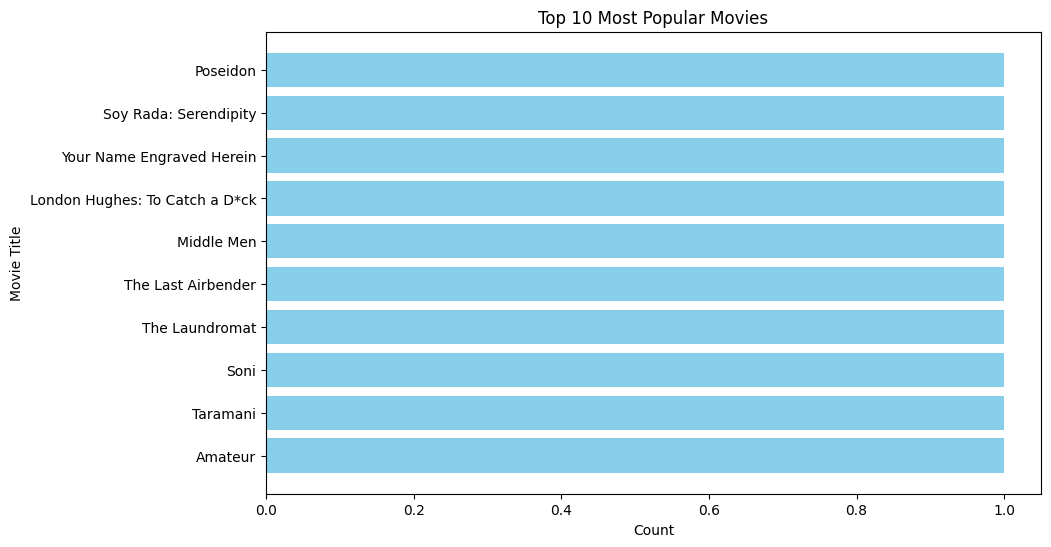

In [ ]:
# Plot top 10 most popular movies
top_movies = df.groupBy("title").count().orderBy("count", ascending=False).limit(10).toPandas()
plt.figure(figsize=(10, 6))
plt.barh(top_movies["title"], top_movies["count"], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Movie Title')
plt.title('Top 10 Most Popular Movies')
plt.gca().invert_yaxis()
plt.show()

## Highest rated movies

In [ ]:
high_rated_movies = df.orderBy("rating", ascending=False).limit(10)
print("Top 10 highest-rated movies:")
high_rated_movies.show()


Top 10 highest-rated movies:
+-------+-----+--------------------+--------------------+--------------------+--------------------+-----------------+------------+--------+--------+--------------------+--------------------+
|show_id| type|               title|            director|                cast|             country|       date_added|release_year|  rating|duration|           listed_in|         description|
+-------+-----+--------------------+--------------------+--------------------+--------------------+-----------------+------------+--------+--------+--------------------+--------------------+
|  s7059|Movie|       Immoral Tales|  Walerian Borowczyk|Lise Danvers, Fab...|              France|     June 6, 2019|        1974|      UR| 103 min|Dramas, Internati...|This anthology il...|
|  s7989|Movie|            Sex Doll|     Sylvie Verheyde|Hafsia Herzi, Ash...|United Kingdom, F...|    July 10, 2017|        2016|      UR| 103 min|Dramas, Internati...|A high-end call g...|
|  s8791|Movie|Y

## Top movie Genres

In [ ]:
genre_movies = df.select("listed_in", "title")
genre_movies = genre_movies.withColumn("genres", explode(split("listed_in", ",")))
genre_movies = genre_movies.groupBy("genres").agg(count("title").alias("count"))
genre_movies = genre_movies.orderBy("count", ascending=False)
print("Top 10 movie genres:")
genre_movies.show(10)

Top 10 movie genres:
+--------------------+-----+
|              genres|count|
+--------------------+-----+
| International Mo...| 2258|
|              Dramas| 1513|
|            Comedies| 1123|
|  Action & Adventure|  804|
|              Dramas|  772|
|  Independent Movies|  715|
|     Romantic Movies|  576|
|           Thrillers|  481|
|Children & Family...|  469|
|            Comedies|  426|
+--------------------+-----+
only showing top 10 rows



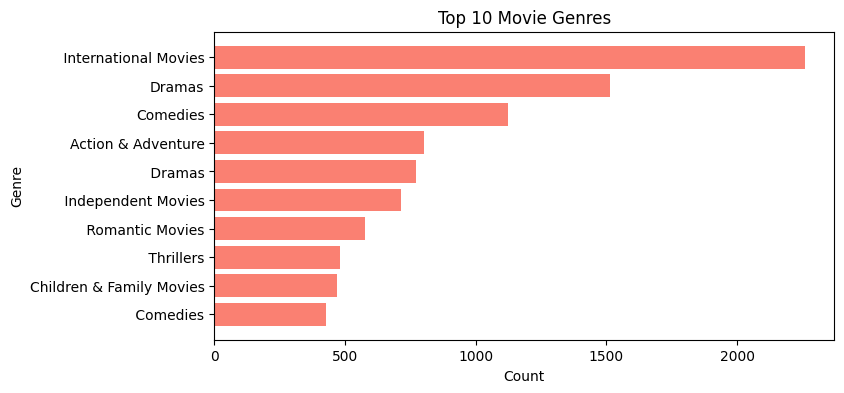

In [ ]:
# Plot top 10 movie genres
genre_movies = df.select(explode(split("listed_in", ",")).alias("genre")).groupBy("genre").count().orderBy("count", ascending=False).limit(10).toPandas()
plt.figure(figsize=(8, 4))
plt.barh(genre_movies["genre"], genre_movies["count"], color='salmon')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Top 10 Movie Genres')
plt.gca().invert_yaxis()
plt.show()

## Rating Distribution

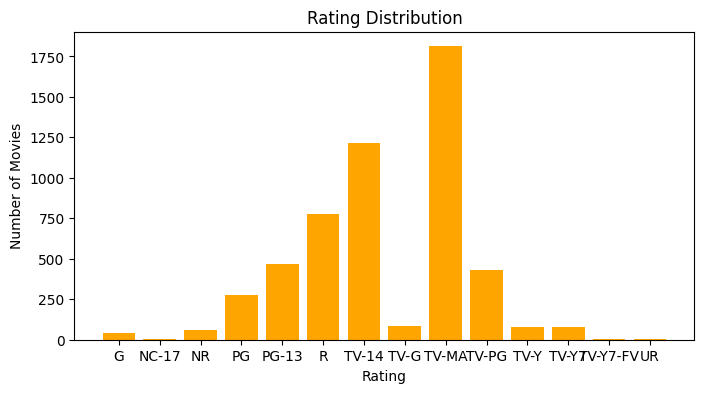

In [ ]:
# Plot rating distribution
rating_distribution = df.groupBy("rating").count().orderBy("rating").toPandas()
plt.figure(figsize=(8, 4))
plt.bar(rating_distribution["rating"], rating_distribution["count"], color='orange')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.title('Rating Distribution')
plt.show()

## Release year distribution

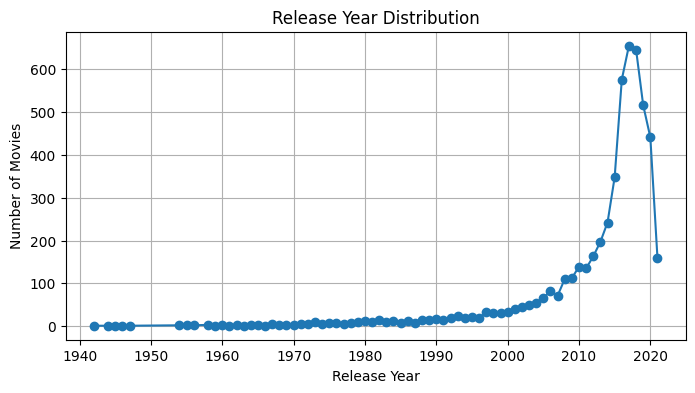

In [ ]:
# Plot release year distribution
release_year_distribution = df.groupBy("release_year").count().orderBy("release_year").toPandas()
plt.figure(figsize=(8, 4))
plt.plot(release_year_distribution["release_year"], release_year_distribution["count"], marker='o', linestyle='-')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Release Year Distribution')
plt.grid(True)
plt.show()


# Build a movie recommendation system


In [ ]:
# Data encoding
indexer = StringIndexer(inputCols=["show_id", "type", "title", "director", "cast", "country", "rating", "duration", "listed_in"], outputCols=["show_id_index", "type_index", "title_index", "director_index", "cast_index", "country_index", "rating_index", "duration_index", "listed_in_index"])
df_encoded = indexer.fit(df).transform(df)

In [ ]:
# Columns to be indexed
cols_to_index = ["show_id", "type", "title", "director", "cast", "country", "rating", "duration", "listed_in"]

# Create a StringIndexer for each column and collect the output columns
index_output_cols = []
for col_name in cols_to_index:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
    df = indexer.fit(df).transform(df)
    index_output_cols.append(f"{col_name}_index")

# df with index values
index_df = df.select(*index_output_cols)
index_df.show()

+-------------+----------+-----------+--------------+----------+-------------+------------+--------------+---------------+
|show_id_index|type_index|title_index|director_index|cast_index|country_index|rating_index|duration_index|listed_in_index|
+-------------+----------+-----------+--------------+----------+-------------+------------+--------------+---------------+
|       4616.0|       0.0|     3673.0|        1822.0|    2748.0|        558.0|         0.0|          53.0|            3.0|
|       5248.0|       1.0|     4386.0|         955.0|    3275.0|          2.0|         1.0|         149.0|          258.0|
|          0.0|       0.0|     4718.0|        3679.0|    3281.0|          0.0|         3.0|          15.0|           38.0|
|        175.0|       0.0|     2146.0|        1314.0|    3013.0|        281.0|         0.0|          42.0|            0.0|
|        955.0|       0.0|     2148.0|        3341.0|    3856.0|          1.0|         1.0|         120.0|            8.0|
|       1151.0| 

In [ ]:
# Split the data into training and testing sets
(train, test) = index_df.randomSplit([0.8, 0.2])

In [ ]:
# Train the ALS model
als = ALS(maxIter=5, regParam=0.01, userCol="show_id_index", itemCol="title_index", ratingCol="rating_index")

model = als.fit(train)

# Make predictions on the test set
preds = model.transform(test)

In [ ]:
# Generate predictions on the test data
predictions = preds.withColumn("prediction", expr("CASE WHEN prediction < 1 THEN 1 WHEN prediction > 5 THEN 5 ELSE prediction END"))
print(predictions)


DataFrame[show_id_index: double, type_index: double, title_index: double, director_index: double, cast_index: double, country_index: double, rating_index: double, duration_index: double, listed_in_index: double, prediction: float]


In [ ]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating_index', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 3.7197171402362885
